In [1]:
# The Coca-Cola Company dataset
# https://finance.yahoo.com/quote/KO/history
# Time Period: Jan 03, 1962 - Oct 31, 2022 Daily Prices

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import time, math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

         Date      Open      High       Low     Close  Adj Close   Volume
0  1962-01-03  0.259115  0.259115  0.253255  0.257161   0.048902  1574400
1  1962-01-04  0.257813  0.261068  0.257813  0.259115   0.049273   844800
2  1962-01-05  0.259115  0.262370  0.252604  0.253255   0.048159  1420800
3  1962-01-08  0.251302  0.251302  0.245768  0.250651   0.047664  2035200
4  1962-01-09  0.250651  0.256510  0.248698  0.255208   0.048530   960000
         Date     Close
0  1962-01-03  0.257161
1  1962-01-04  0.259115
2  1962-01-05  0.253255
3  1962-01-08  0.250651
4  1962-01-09  0.255208


c:\Users\lizhe.DESKTOP-KN754PS\anaconda3\envs\ptenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


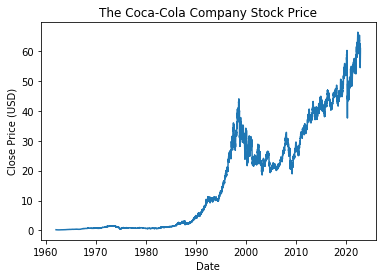

In [2]:
def to_datetime(date):
    d = date.split('-')
    yy,mm,dd = int(d[0]), int(d[1]), int(d[2])
    return dt.datetime(yy,mm,dd)

def read_data(data, company):
    d = pd.read_csv(data)
    df = d[['Date', 'Close']]
    print(d.head())
    print(df.head())
    df['Date'] = df['Date'].apply(to_datetime)
    return df

def plot_data(df, company):
    # plot scaled data
    plt.plot(df['Date'], df['Close'])
    plt.title("{} Stock Price".format(company))
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.show()

def preprocessing(data, window_size, test_split):
    data = df.filter(['Close'])
    dataset = data.values
    
    # scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    data['Close'] = scaler.fit_transform(dataset)
    data_raw = data.to_numpy()

    d = []
    for index in range(len(data_raw) - window_size): 
        d.append(data_raw[index: index + window_size])
    d = np.array(d)

    train_size = len(d)-int(np.round(test_split*len(d))) + 1
    return [d[:train_size,:-1,:], d[:train_size,-1,:], d[train_size:,:-1], d[train_size:,-1,:]], scaler


df = read_data('KO.csv', 'The Coca-Cola Company')
plot_data(df, 'The Coca-Cola Company')


In [4]:
class LSTM(nn.Module):
    def __init__(self, input, hidden, num_layers, output):
        super(LSTM, self).__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input, hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden, output)
        
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100):
    # train model
    losses = np.zeros(epochs)
    for t in range(epochs):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        losses[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # calculate MSE & RMSE
    y_pred = scaler.inverse_transform(y_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train.detach().numpy())
    MSE = np.round(mean_squared_error(y_train[:,0], y_pred[:,0]),3)
    RMSE = np.round(math.sqrt(mean_squared_error(y_train[:,0], y_pred[:,0])),3)
    print('Train Score: {} MSE, {} RMSE'.format(MSE, RMSE))

    predict = pd.DataFrame(y_pred)
    target = pd.DataFrame(y_train)

    return predict, target, losses

def plot_traning(predict, target, losses):
    # plot training process
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss')
    
    fig.set_figheight(6)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 2)
    plt.plot(target.index, target[0], label="Actual Price")
    plt.plot(predict.index, predict[0], label="Prediction Price of Training Data")
    plt.title('Stock Price')
    plt.xlabel("Days")
    plt.ylabel("$ (USD)")
    plt.legend()
    plt.show()

In [6]:
def predicting(x_test, y_test, model, scaler):
    # make predictions
    y_pred = model(x_test)
    y_pred = scaler.inverse_transform(y_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test.detach().numpy())

    # calculate MSE & RMSE
    MSE = np.round(mean_squared_error(y_test[:,0], y_pred[:,0]),3)
    RMSE = np.round(math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0])),3)
    print('Train Score: {} MSE, {} RMSE'.format(MSE, RMSE))


### (1) window_size = 10

In [7]:
window_size = 10

[x_train, y_train, x_test, y_test], scaler = preprocessing(df, window_size, 0.2)
# convert to torch tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

model = LSTM(input=1, hidden=32, output=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
predict, target, losses = training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100)

Epoch  0 MSE:  0.04375307261943817
Epoch  1 MSE:  0.031281985342502594
Epoch  2 MSE:  0.03432280942797661
Epoch  3 MSE:  0.03045700676739216
Epoch  4 MSE:  0.02782426029443741
Epoch  5 MSE:  0.027267998084425926
Epoch  6 MSE:  0.02714100107550621
Epoch  7 MSE:  0.02574632689356804
Epoch  8 MSE:  0.02243523858487606
Epoch  9 MSE:  0.01771312765777111
Epoch  10 MSE:  0.013693473301827908
Epoch  11 MSE:  0.009538989514112473
Epoch  12 MSE:  0.002029844792559743
Epoch  13 MSE:  0.0031527038663625717
Epoch  14 MSE:  0.008097763173282146
Epoch  15 MSE:  0.004346916452050209
Epoch  16 MSE:  0.0007635274669155478
Epoch  17 MSE:  0.0004443589714355767
Epoch  18 MSE:  0.001894729328341782
Epoch  19 MSE:  0.0030766979325562716
Epoch  20 MSE:  0.00342259812168777
Epoch  21 MSE:  0.003044459968805313
Epoch  22 MSE:  0.0022393367253243923
Epoch  23 MSE:  0.0013124338584020734
Epoch  24 MSE:  0.0006040881271474063
Epoch  25 MSE:  0.0005101339193060994
Epoch  26 MSE:  0.0009480883600190282
Epoch  27 M

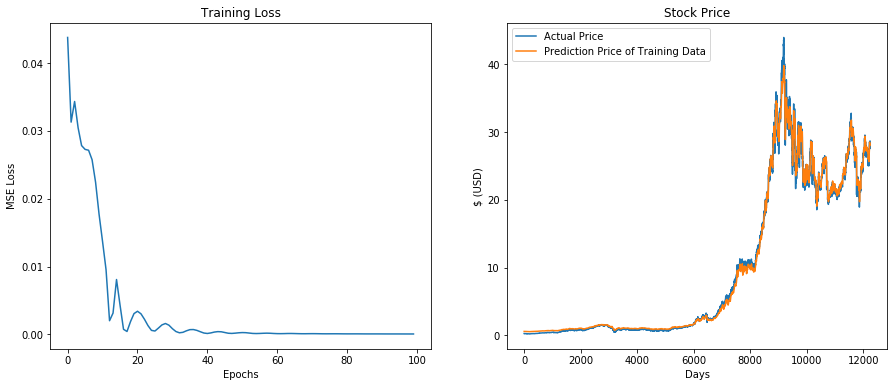

In [8]:
plot_traning(predict, target, losses)

In [9]:
predicting(x_test, y_test, model, scaler)

Train Score: 38.87900161743164 MSE, 6.235 RMSE


### (2) window_size=20

In [17]:
window_size = 20

[x_train, y_train, x_test, y_test], scaler = preprocessing(df, window_size, 0.2)
# convert to torch tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

model = LSTM(input=1, hidden=32, output=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
predict2, target2, losses2 = training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100)

Epoch  0 MSE:  0.053301021456718445
Epoch  1 MSE:  0.0312313511967659
Epoch  2 MSE:  0.03212617337703705
Epoch  3 MSE:  0.03434591740369797
Epoch  4 MSE:  0.030898187309503555
Epoch  5 MSE:  0.02796577475965023
Epoch  6 MSE:  0.02704218029975891
Epoch  7 MSE:  0.02719411440193653
Epoch  8 MSE:  0.027206039056181908
Epoch  9 MSE:  0.02634163200855255
Epoch  10 MSE:  0.02445962093770504
Epoch  11 MSE:  0.021830091252923012
Epoch  12 MSE:  0.019007036462426186
Epoch  13 MSE:  0.016701554879546165
Epoch  14 MSE:  0.014763261191546917
Epoch  15 MSE:  0.01144061516970396
Epoch  16 MSE:  0.00626053661108017
Epoch  17 MSE:  0.0016311474610120058
Epoch  18 MSE:  0.0011234739795327187
Epoch  19 MSE:  0.0034991465508937836
Epoch  20 MSE:  0.006844729650765657
Epoch  21 MSE:  0.006494622211903334
Epoch  22 MSE:  0.0034238137304782867
Epoch  23 MSE:  0.0014473948394879699
Epoch  24 MSE:  0.0005908904713578522
Epoch  25 MSE:  0.0005672123515978456
Epoch  26 MSE:  0.0011969460174441338
Epoch  27 MSE:

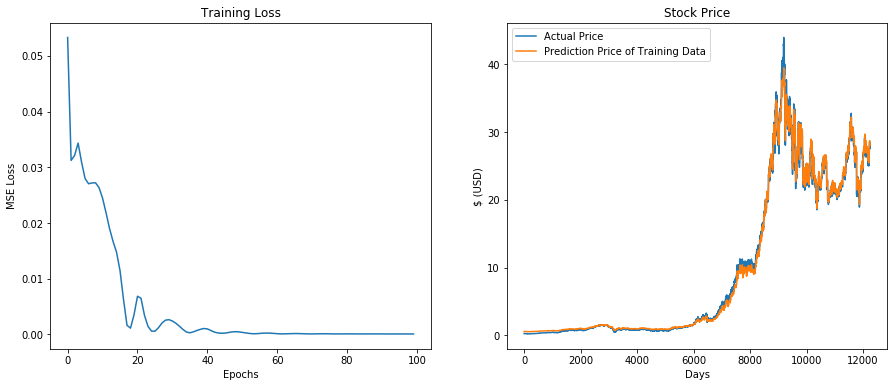

In [18]:
plot_traning(predict2, target2, losses2)

In [19]:
predicting(x_test, y_test, model, scaler)

Train Score: 45.422000885009766 MSE, 6.74 RMSE
